In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import copy
from google.colab import drive
import os
import torch.nn.functional as F
import random



drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/adonet_data')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"현재 작업 디렉토리: {os.getcwd()} 현재 디바이스: {device}")
pd.set_option('display.max_rows',    None)
pd.set_option('display.max_columns', None)


#------------Import Data---------------
csv_path_cnt= ('Connectome.csv')
cntset = pd.read_csv(csv_path_cnt)
csv_path_ann= ('DoOR.csv')
X_ann = pd.read_csv(csv_path_ann)

ff=cntset[cntset["directionality"]=='feedforward']
otp=ff[(ff["pre_class"]=='ORN') & (ff["post_class"]=='ALPN')]
ptk=ff[(ff['pre_class']=='ALPN') & (ff['post_class']=='KC')]

#-----------ORN to ALPN mask: 'mask_otp'-----------------
otp_unique = otp[['pre_root_id','post_root_id']]
mask_otp_norm = pd.crosstab(
    index=otp_unique['pre_root_id'],    # Row: ORN ID
    columns=otp_unique['post_root_id']  # Column: ALPN ID
    , values=otp['syn_count']           # syn count
    , aggfunc='sum'
    ).fillna(0)                         #NaN = 0

def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

Mounted at /content/drive
현재 작업 디렉토리: /content/drive/MyDrive/adonet_data 현재 디바이스: cuda


# Weight1: Synapse counts normalized

Normalized by Max value

In [ ]:
#-----------ORN to ALPN mask: 'mask_otp'-----------------
otp_unique = otp[['pre_root_id','post_root_id']]
mask_otp_norm = pd.crosstab(
    index=otp_unique['pre_root_id'],    # Row: ORN ID
    columns=otp_unique['post_root_id']  # Column: ALPN ID
    , values=otp['syn_count']           # syn count
    , aggfunc='sum'
    ).fillna(0)                         #NaN = 0

mask_otp = torch.from_numpy(mask_otp_norm.T.values).float().to(device)  # (615, 2278)

#------------ALPN to KC mask: 'mask_ptk'-----------------
alpn_ids=mask_otp_norm.columns

ptk_unique=ptk[['pre_root_id', 'post_root_id']]
mask_ptk_norm = (
    pd.crosstab(
        index=ptk_unique['pre_root_id'],    # Row: ALPN ID
        columns=ptk_unique['post_root_id'], # Column: KC ID
        values=ptk['syn_count'],
        aggfunc='sum'
    )
    .reindex(index=alpn_ids,   # Make ALPN ID 615
             fill_value=0)
    .fillna(0)                 # NaN = 0
)
mask_ptk = torch.from_numpy(mask_ptk_norm.T.values).float().to(device)  # (4907,334)


#-----------Neormalization by Max: 'mask_otp_n' & 'mask_ptk_n'------
def normalize_by_max_(x):
    y=x/x.max()
    return y
mask_otp_n=normalize_by_max_(mask_otp)
mask_ptk_n=normalize_by_max_(mask_ptk)

#-----------------------MaskedLinear()----------------------------
class MaskedLinear(nn.Module):
    def __init__(self, in_features, out_features, weight):
        super().__init__()
        self.weight = nn.Parameter(weight)
        self.bias   = nn.Parameter(torch.zeros(out_features))

        self.register_buffer('mask', weight>0)    # +1/-1/0 mask

    def forward(self, x):
        w = self.weight * self.mask
        # Use functional linear transformation
        return torch.nn.functional.linear(x, w, self.bias)

#---------------------Odor Classifier()---------------------------
class Odor_classifier(nn.Module):
  def __init__(self,input_dim,output_dim, mask1, mask2):
    super().__init__()
    self.net=nn.Sequential(
        MaskedLinear(input_dim,615, mask1),
        nn.ReLU(),
        MaskedLinear(615,4907, mask2),
        nn.ReLU(),
        nn.Linear(4907,output_dim)
    )
  def forward(self, x):
    return self.net(x)

per = [1,2,3]
syn_max_list = {250*i : [] for i in per}


for q in range(10):
    set_seed(q)
    print(f"-------------------------------{q}번째-----------------------------------")
    for p in per:
        model = Odor_classifier(input_dim=2278, output_dim=250, mask1=mask_otp_n, mask2=mask_ptk_n).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        #-----------------------Train & Test----------------------
        cls_labels = []
        for i in range(250):
            cls_labels.append(f'Odor_({i+1})')

        le=LabelEncoder()
        y_int=le.fit_transform(cls_labels)
        y = y_int
        y_out=torch.tensor(y,dtype=torch.long)

        x_train=[]
        y_train=[]
        x_test=[]
        y_test=[]

        arr_train = np.arange(250)
        arr2_train = np.tile(arr_train, p)
        np.random.shuffle(arr2_train)

        for n in arr2_train:
            noise=torch.normal(mean=0,std=0.2,size=(2278,))
            xi = pd.to_numeric(X_ann.iloc[n, 1:], errors='coerce')
            xn  = torch.zeros(2278, dtype=torch.float32)
            xn = torch.tensor(xi.fillna(0).values, dtype=torch.float32) + noise
            x_train.append(xn)
            y_train.append(y_out[n])

        arr_test = np.arange(250)
        arr2_test = np.tile(arr_test, 2)
        np.random.shuffle(arr2_test)

        for k in arr2_test:
            noise=torch.normal(mean=0,std=0.4,size=(2278,))
            xi = pd.to_numeric(X_ann.iloc[k, 1:], errors='coerce')
            xn  = torch.zeros(2278, dtype=torch.float32)
            xn = torch.tensor(xi.fillna(0).values, dtype=torch.float32) + noise
            x_test.append(xn)
            y_test.append(y_out[k])

        x_train = torch.stack(x_train).to(dtype=torch.float32)
        y_train = torch.stack(y_train).to(dtype=torch.long)
        x_test = torch.stack(x_test).to(dtype=torch.float32)
        y_test = torch.stack(y_test).to(dtype=torch.long)

        train_ds = TensorDataset(x_train, y_train)
        test_ds  = TensorDataset(x_test,  y_test)

        train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
        test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False)

        #---------------Train loop----------------
        num_epochs = 100
        train_losses, train_accs = [], []
        test_losses,  test_accs  = [], []

        for epoch in trange(num_epochs, desc="Epochs"):
            model.train()
            tr_loss = tr_acc = 0.0
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                logits = model(xb)
                loss   = criterion(logits, yb)
                loss.backward()
                optimizer.step()

                tr_loss += loss.item() * xb.size(0)
                tr_acc  += (logits.argmax(dim=1) == yb).float().sum().item()

            tr_loss /= len(train_loader.dataset)
            tr_acc  /= len(train_loader.dataset)
            train_losses.append(tr_loss)
            train_accs.append(tr_acc)

        # ==== 여기서 test curve 기록 ====
        model.eval()
        te_loss = te_acc = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                te_loss += loss.item() * xb.size(0)
                te_acc  += (logits.argmax(dim=1) == yb).float().sum().item()
        te_loss /= len(test_loader.dataset)
        te_acc  /= len(test_loader.dataset)

        syn_max_list[250*p].append(te_acc)

        print(f"Epoch {epoch+1:02d}/{num_epochs}  "
              f"Test Loss: {te_loss:.4f}, Test Acc {250*p}: {te_acc:.4%}")
        print(f"--------------------------------few shot syn max: {250*p} ---------------------------------------------")
    print()

-------------------------------0번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 15.62it/s]


Epoch 100/100  Test Loss: 2.5823, Test Acc 250: 44.8000%
--------------------------------few shot syn max: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Epoch 100/100  Test Loss: 1.4008, Test Acc 500: 68.0000%
--------------------------------few shot syn max: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


Epoch 100/100  Test Loss: 1.1240, Test Acc 750: 73.8000%
--------------------------------few shot syn max: 750 ---------------------------------------------

-------------------------------1번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 16.13it/s]


Epoch 100/100  Test Loss: 1.5193, Test Acc 250: 67.6000%
--------------------------------few shot syn max: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 100/100  Test Loss: 1.0501, Test Acc 500: 75.4000%
--------------------------------few shot syn max: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


Epoch 100/100  Test Loss: 0.8755, Test Acc 750: 79.8000%
--------------------------------few shot syn max: 750 ---------------------------------------------

-------------------------------2번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 16.65it/s]


Epoch 100/100  Test Loss: 1.3347, Test Acc 250: 69.4000%
--------------------------------few shot syn max: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  7.94it/s]


Epoch 100/100  Test Loss: 1.0478, Test Acc 500: 74.6000%
--------------------------------few shot syn max: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


Epoch 100/100  Test Loss: 0.8069, Test Acc 750: 78.0000%
--------------------------------few shot syn max: 750 ---------------------------------------------

-------------------------------3번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:05<00:00, 16.86it/s]


Epoch 100/100  Test Loss: 1.4446, Test Acc 250: 68.8000%
--------------------------------few shot syn max: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Epoch 100/100  Test Loss: 1.0115, Test Acc 500: 75.2000%
--------------------------------few shot syn max: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


Epoch 100/100  Test Loss: 0.9562, Test Acc 750: 79.2000%
--------------------------------few shot syn max: 750 ---------------------------------------------

-------------------------------4번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 16.46it/s]


Epoch 100/100  Test Loss: 1.3278, Test Acc 250: 68.0000%
--------------------------------few shot syn max: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch 100/100  Test Loss: 0.9072, Test Acc 500: 77.2000%
--------------------------------few shot syn max: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Epoch 100/100  Test Loss: 0.7323, Test Acc 750: 82.0000%
--------------------------------few shot syn max: 750 ---------------------------------------------

-------------------------------5번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 15.71it/s]


Epoch 100/100  Test Loss: 1.2268, Test Acc 250: 69.0000%
--------------------------------few shot syn max: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Epoch 100/100  Test Loss: 0.9272, Test Acc 500: 77.2000%
--------------------------------few shot syn max: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


Epoch 100/100  Test Loss: 0.8534, Test Acc 750: 80.6000%
--------------------------------few shot syn max: 750 ---------------------------------------------

-------------------------------6번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 15.82it/s]


Epoch 100/100  Test Loss: 1.3385, Test Acc 250: 68.8000%
--------------------------------few shot syn max: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 100/100  Test Loss: 0.9725, Test Acc 500: 74.6000%
--------------------------------few shot syn max: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


Epoch 100/100  Test Loss: 0.8947, Test Acc 750: 77.8000%
--------------------------------few shot syn max: 750 ---------------------------------------------

-------------------------------7번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 16.33it/s]


Epoch 100/100  Test Loss: 1.2409, Test Acc 250: 71.4000%
--------------------------------few shot syn max: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Epoch 100/100  Test Loss: 1.0212, Test Acc 500: 77.4000%
--------------------------------few shot syn max: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


Epoch 100/100  Test Loss: 0.9222, Test Acc 750: 77.2000%
--------------------------------few shot syn max: 750 ---------------------------------------------

-------------------------------8번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:05<00:00, 16.73it/s]


Epoch 100/100  Test Loss: 1.4015, Test Acc 250: 68.2000%
--------------------------------few shot syn max: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 100/100  Test Loss: 0.9040, Test Acc 500: 80.4000%
--------------------------------few shot syn max: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Epoch 100/100  Test Loss: 0.7516, Test Acc 750: 81.0000%
--------------------------------few shot syn max: 750 ---------------------------------------------

-------------------------------9번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:05<00:00, 16.73it/s]


Epoch 100/100  Test Loss: 1.2260, Test Acc 250: 73.2000%
--------------------------------few shot syn max: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.12it/s]


Epoch 100/100  Test Loss: 0.9481, Test Acc 500: 79.2000%
--------------------------------few shot syn max: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


Epoch 100/100  Test Loss: 0.8614, Test Acc 750: 82.0000%
--------------------------------few shot syn max: 750 ---------------------------------------------



In [ ]:
print(syn_max_list)

{1000: [0.796, 0.84, 0.846, 0.836, 0.844, 0.846, 0.85, 0.818, 0.824, 0.814], 2000: [0.844, 0.844, 0.846, 0.86, 0.862, 0.834, 0.848, 0.848, 0.854, 0.84]}


Raw Synapse counts

In [ ]:
#-----------ORN to ALPN mask: 'mask_otp'-----------------
otp_unique = otp[['pre_root_id','post_root_id']]
mask_otp_norm = pd.crosstab(
    index=otp_unique['pre_root_id'],    # Row: ORN ID
    columns=otp_unique['post_root_id']  # Column: ALPN ID
    , values=otp['syn_count']           # syn count
    , aggfunc='sum'
    ).fillna(0)                         #NaN = 0

mask_otp = torch.from_numpy(mask_otp_norm.T.values).float().to(device)  # (615, 2278)

#------------ALPN to KC mask: 'mask_ptk'-----------------
alpn_ids=mask_otp_norm.columns

ptk_unique=ptk[['pre_root_id', 'post_root_id']]
mask_ptk_norm = (
    pd.crosstab(
        index=ptk_unique['pre_root_id'],    # Row: ALPN ID
        columns=ptk_unique['post_root_id'], # Column: KC ID
        values=ptk['syn_count'],
        aggfunc='sum'
    )
    .reindex(index=alpn_ids,   # Make ALPN ID 615
             fill_value=0)
    .fillna(0)                 # NaN = 0
)
mask_ptk = torch.from_numpy(mask_ptk_norm.T.values).float().to(device)  # (4907,334)

#-----------------------MaskedLinear()----------------------------
class MaskedLinear(nn.Module):
    def __init__(self, in_features, out_features, weight):
        super().__init__()
        self.weight = nn.Parameter(weight)
        self.bias   = nn.Parameter(torch.zeros(out_features))

        self.register_buffer('mask', (weight>0).float())    # +1/-1/0 mask

    def forward(self, x):
        w = (self.weight) * self.mask
        # Use functional linear transformation
        return torch.nn.functional.linear(x, w, self.bias)

#---------------------Odor Classifier()---------------------------
class Odor_classifier(nn.Module):
  def __init__(self,input_dim,output_dim, mask1, mask2):
    super().__init__()
    self.net=nn.Sequential(
        MaskedLinear(input_dim,615, mask1),
        nn.ReLU(),
        MaskedLinear(615,4907, mask2),
        nn.ReLU(),
        nn.Linear(4907,output_dim)
    )
  def forward(self, x):
    return self.net(x)

per = [1,2,3]
syn_raw_list = {250*i : [] for i in per}


for q in range(10):
    set_seed(q)
    print(f"-------------------------------{q}번째-----------------------------------")
    for p in per:
        model = Odor_classifier(input_dim=2278, output_dim=250, mask1=mask_otp, mask2=mask_ptk).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        #-----------------------Train & Test----------------------
        cls_labels = []
        for i in range(250):
            cls_labels.append(f'Odor_({i+1})')

        le=LabelEncoder()
        y_int=le.fit_transform(cls_labels)
        y = y_int
        y_out=torch.tensor(y,dtype=torch.long)

        x_train=[]
        y_train=[]
        x_test=[]
        y_test=[]

        arr_train = np.arange(250)
        arr2_train = np.tile(arr_train, p)
        np.random.shuffle(arr2_train)

        for n in arr2_train:
            noise=torch.normal(mean=0,std=0.2,size=(2278,))
            xi = pd.to_numeric(X_ann.iloc[n, 1:], errors='coerce')
            xn  = torch.zeros(2278, dtype=torch.float32)
            xn = torch.tensor(xi.fillna(0).values, dtype=torch.float32) + noise
            x_train.append(xn)
            y_train.append(y_out[n])

        arr_test = np.arange(250)
        arr2_test = np.tile(arr_test, 2)
        np.random.shuffle(arr2_test)

        for k in arr2_test:
            noise=torch.normal(mean=0,std=0.4,size=(2278,))
            xi = pd.to_numeric(X_ann.iloc[k, 1:], errors='coerce')
            xn  = torch.zeros(2278, dtype=torch.float32)
            xn = torch.tensor(xi.fillna(0).values, dtype=torch.float32) + noise
            x_test.append(xn)
            y_test.append(y_out[k])

        x_train = torch.stack(x_train).to(dtype=torch.float32)
        y_train = torch.stack(y_train).to(dtype=torch.long)
        x_test = torch.stack(x_test).to(dtype=torch.float32)
        y_test = torch.stack(y_test).to(dtype=torch.long)

        train_ds = TensorDataset(x_train, y_train)
        test_ds  = TensorDataset(x_test,  y_test)

        train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
        test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False)

        #---------------Train loop----------------
        num_epochs = 100
        train_losses, train_accs = [], []
        test_losses,  test_accs  = [], []

        for epoch in trange(num_epochs, desc="Epochs"):
            model.train()
            tr_loss = tr_acc = 0.0
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                logits = model(xb)
                loss   = criterion(logits, yb)
                loss.backward()
                optimizer.step()

                tr_loss += loss.item() * xb.size(0)
                tr_acc  += (logits.argmax(dim=1) == yb).float().sum().item()

            tr_loss /= len(train_loader.dataset)
            tr_acc  /= len(train_loader.dataset)
            train_losses.append(tr_loss)
            train_accs.append(tr_acc)

        # ==== 여기서 test curve 기록 ====
        model.eval()
        te_loss = te_acc = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                te_loss += loss.item() * xb.size(0)
                te_acc  += (logits.argmax(dim=1) == yb).float().sum().item()
        te_loss /= len(test_loader.dataset)
        te_acc  /= len(test_loader.dataset)

        syn_raw_list[250*p].append(te_acc)

        print(f"Epoch {epoch+1:02d}/{num_epochs}  "
              f"Test Loss: {te_loss:.4f}, Test Acc {250*p}: {te_acc:.4%}")
        print(f"--------------------------------few shot syn raw: {250*p} ---------------------------------------------")
    print()

-------------------------------0번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 15.45it/s]


Epoch 100/100  Test Loss: 8826.7082, Test Acc 250: 24.4000%
--------------------------------few shot syn raw: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch 100/100  Test Loss: 7596.3564, Test Acc 500: 37.4000%
--------------------------------few shot syn raw: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


Epoch 100/100  Test Loss: 8420.6727, Test Acc 750: 43.2000%
--------------------------------few shot syn raw: 750 ---------------------------------------------

-------------------------------1번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:05<00:00, 16.85it/s]


Epoch 100/100  Test Loss: 9836.8088, Test Acc 250: 22.4000%
--------------------------------few shot syn raw: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


Epoch 100/100  Test Loss: 7994.4779, Test Acc 500: 38.0000%
--------------------------------few shot syn raw: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


Epoch 100/100  Test Loss: 7303.9957, Test Acc 750: 47.4000%
--------------------------------few shot syn raw: 750 ---------------------------------------------

-------------------------------2번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:05<00:00, 16.76it/s]


Epoch 100/100  Test Loss: 9124.1200, Test Acc 250: 26.2000%
--------------------------------few shot syn raw: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Epoch 100/100  Test Loss: 8608.9818, Test Acc 500: 35.6000%
--------------------------------few shot syn raw: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


Epoch 100/100  Test Loss: 12579.6904, Test Acc 750: 31.0000%
--------------------------------few shot syn raw: 750 ---------------------------------------------

-------------------------------3번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 16.34it/s]


Epoch 100/100  Test Loss: 10310.4001, Test Acc 250: 21.8000%
--------------------------------few shot syn raw: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 100/100  Test Loss: 8766.2992, Test Acc 500: 35.0000%
--------------------------------few shot syn raw: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


Epoch 100/100  Test Loss: 10789.2610, Test Acc 750: 36.0000%
--------------------------------few shot syn raw: 750 ---------------------------------------------

-------------------------------4번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 15.90it/s]


Epoch 100/100  Test Loss: 6750.9672, Test Acc 250: 30.4000%
--------------------------------few shot syn raw: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 100/100  Test Loss: 7714.5072, Test Acc 500: 38.4000%
--------------------------------few shot syn raw: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


Epoch 100/100  Test Loss: 5524.0232, Test Acc 750: 46.0000%
--------------------------------few shot syn raw: 750 ---------------------------------------------

-------------------------------5번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 15.85it/s]


Epoch 100/100  Test Loss: 9805.6050, Test Acc 250: 20.6000%
--------------------------------few shot syn raw: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.12it/s]


Epoch 100/100  Test Loss: 9975.7730, Test Acc 500: 31.8000%
--------------------------------few shot syn raw: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


Epoch 100/100  Test Loss: 9826.2177, Test Acc 750: 41.2000%
--------------------------------few shot syn raw: 750 ---------------------------------------------

-------------------------------6번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 15.81it/s]


Epoch 100/100  Test Loss: 7635.8604, Test Acc 250: 32.2000%
--------------------------------few shot syn raw: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Epoch 100/100  Test Loss: 7095.7234, Test Acc 500: 37.6000%
--------------------------------few shot syn raw: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


Epoch 100/100  Test Loss: 7419.1821, Test Acc 750: 47.6000%
--------------------------------few shot syn raw: 750 ---------------------------------------------

-------------------------------7번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 16.36it/s]


Epoch 100/100  Test Loss: 10049.9415, Test Acc 250: 20.8000%
--------------------------------few shot syn raw: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Epoch 100/100  Test Loss: 8956.1175, Test Acc 500: 37.0000%
--------------------------------few shot syn raw: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


Epoch 100/100  Test Loss: 11329.2509, Test Acc 750: 36.2000%
--------------------------------few shot syn raw: 750 ---------------------------------------------

-------------------------------8번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:05<00:00, 16.70it/s]


Epoch 100/100  Test Loss: 8508.9303, Test Acc 250: 19.4000%
--------------------------------few shot syn raw: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Epoch 100/100  Test Loss: 7730.2503, Test Acc 500: 37.4000%
--------------------------------few shot syn raw: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


Epoch 100/100  Test Loss: 9982.4651, Test Acc 750: 37.8000%
--------------------------------few shot syn raw: 750 ---------------------------------------------

-------------------------------9번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:05<00:00, 16.68it/s]


Epoch 100/100  Test Loss: 8867.9995, Test Acc 250: 21.4000%
--------------------------------few shot syn raw: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  7.89it/s]


Epoch 100/100  Test Loss: 9221.2966, Test Acc 500: 32.8000%
--------------------------------few shot syn raw: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


Epoch 100/100  Test Loss: 9006.9774, Test Acc 750: 44.2000%
--------------------------------few shot syn raw: 750 ---------------------------------------------



# Weight 2: ORN to PN & PN to KC total random value

UNiform(0~1)

In [ ]:
#-----------ORN to ALPN mask: 'mask_otp'-----------------
otp_unique = otp[['pre_root_id','post_root_id']]
mask_otp_norm = pd.crosstab(
    index=otp_unique['pre_root_id'],    # Row: ORN ID
    columns=otp_unique['post_root_id']  # Column: ALPN ID
    , values=otp['syn_count']           # syn count
    , aggfunc='sum'
    ).fillna(0)                         #NaN = 0

mask_otp = torch.from_numpy(mask_otp_norm.T.values).float().to(device)  # (615, 2278)

#------------ORN to ALPN mask: 'mask_otp'-----------------
alpn_ids=mask_otp_norm.columns

ptk_unique=ptk[['pre_root_id', 'post_root_id']]
mask_ptk_norm = (
    pd.crosstab(
        index=ptk_unique['pre_root_id'],    # Row: ALPN ID
        columns=ptk_unique['post_root_id'], # Column: KC ID
        values=ptk['syn_count'],
        aggfunc='sum'
    )
    .reindex(index=alpn_ids,   # Make ALPN ID 615
             fill_value=0)
    .fillna(0)                 # NaN = 0
)
mask_ptk = torch.from_numpy(mask_ptk_norm.T.values).float().to(device)  # (4907,334)

#-----------------------MaskedLinear()----------------------------
class MaskedLinear(nn.Module):
    def __init__(self, in_features, out_features, init_weight):
        super().__init__()
        self.register_buffer('mask', (init_weight>0).float().to(init_weight.device)) # Ensure mask is on the same device
        self.weight = nn.Parameter(torch.zeros(out_features, in_features, device=init_weight.device)) # Initialize weight on the same device
        nn.init.uniform_(self.weight, a=0, b=1)
        self.bias   = nn.Parameter(torch.zeros(out_features, device=init_weight.device)) # Initialize bias on the same device

    def forward(self, x):
        w = self.weight * self.mask
        return F.linear(x, w, self.bias)

#---------------------Odor Classifier()---------------------------
class Odor_classifier(nn.Module):
  def __init__(self,input_dim,output_dim, mask1, mask2):
    super().__init__()
    self.net=nn.Sequential(
        MaskedLinear(input_dim,615, mask1),
        nn.ReLU(),
        MaskedLinear(615,4907, mask2),
        nn.ReLU(),
        nn.Linear(4907,output_dim)
    )
  def forward(self, x):
    return self.net(x)

per = [1,2,3]
ran_uni_list = {250*i : [] for i in per}


for q in range(10):
    set_seed(q)
    print(f"-------------------------------{q+1}번째-----------------------------------")
    for p in per:
        model = Odor_classifier(input_dim=2278, output_dim=250, mask1=mask_otp, mask2=mask_ptk).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        #-----------------------Train & Test----------------------
        cls_labels = []
        for i in range(250):
            cls_labels.append(f'Odor_({i+1})')

        le=LabelEncoder()
        y_int=le.fit_transform(cls_labels)
        y = y_int
        y_out=torch.tensor(y,dtype=torch.long)

        x_train=[]
        y_train=[]
        x_test=[]
        y_test=[]

        arr_train = np.arange(250)
        arr2_train = np.tile(arr_train, p)
        np.random.shuffle(arr2_train)

        for n in arr2_train:
            noise=torch.normal(mean=0,std=0.2,size=(2278,))
            xi = pd.to_numeric(X_ann.iloc[n, 1:], errors='coerce')
            xn  = torch.zeros(2278, dtype=torch.float32)
            xn = torch.tensor(xi.fillna(0).values, dtype=torch.float32) + noise
            x_train.append(xn)
            y_train.append(y_out[n])

        arr_test = np.arange(250)
        arr2_test = np.tile(arr_test, 2)
        np.random.shuffle(arr2_test)

        for k in arr2_test:
            noise=torch.normal(mean=0,std=0.4,size=(2278,))
            xi = pd.to_numeric(X_ann.iloc[k, 1:], errors='coerce')
            xn  = torch.zeros(2278, dtype=torch.float32)
            xn = torch.tensor(xi.fillna(0).values, dtype=torch.float32) + noise
            x_test.append(xn)
            y_test.append(y_out[k])

        x_train = torch.stack(x_train).to(dtype=torch.float32)
        y_train = torch.stack(y_train).to(dtype=torch.long)
        x_test = torch.stack(x_test).to(dtype=torch.float32)
        y_test = torch.stack(y_test).to(dtype=torch.long)

        train_ds = TensorDataset(x_train, y_train)
        test_ds  = TensorDataset(x_test,  y_test)

        train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
        test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False)

        #---------------Train loop----------------
        num_epochs = 100
        train_losses, train_accs = [], []
        test_losses,  test_accs  = [], []

        for epoch in trange(num_epochs, desc="Epochs"):
            model.train()
            tr_loss = tr_acc = 0.0
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                logits = model(xb)
                loss   = criterion(logits, yb)
                loss.backward()
                optimizer.step()

                tr_loss += loss.item() * xb.size(0)
                tr_acc  += (logits.argmax(dim=1) == yb).float().sum().item()

            tr_loss /= len(train_loader.dataset)
            tr_acc  /= len(train_loader.dataset)
            train_losses.append(tr_loss)
            train_accs.append(tr_acc)

        # ==== 여기서 test curve 기록 ====
        model.eval()
        te_loss = te_acc = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                te_loss += loss.item() * xb.size(0)
                te_acc  += (logits.argmax(dim=1) == yb).float().sum().item()
        te_loss /= len(test_loader.dataset)
        te_acc  /= len(test_loader.dataset)

        ran_uni_list[250*p].append(te_acc)

        print(f"Epoch {epoch+1:02d}/{num_epochs}  "
              f"Test Loss: {te_loss:.4f}, Test Acc {250*p}: {te_acc:.4%}")
        print(f"--------------------------------few shot ran uni: {250*p} ---------------------------------------------")
    print()


-------------------------------1번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 16.06it/s]


Epoch 100/100  Test Loss: 2.1111, Test Acc 250: 49.8000%
--------------------------------few shot ran uni: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


Epoch 100/100  Test Loss: 1.6625, Test Acc 500: 60.0000%
--------------------------------few shot ran uni: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.63it/s]


Epoch 100/100  Test Loss: 1.2832, Test Acc 750: 66.4000%
--------------------------------few shot ran uni: 750 ---------------------------------------------

-------------------------------2번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 15.74it/s]


Epoch 100/100  Test Loss: 2.0190, Test Acc 250: 56.2000%
--------------------------------few shot ran uni: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


Epoch 100/100  Test Loss: 1.5257, Test Acc 500: 66.0000%
--------------------------------few shot ran uni: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


Epoch 100/100  Test Loss: 1.3603, Test Acc 750: 67.8000%
--------------------------------few shot ran uni: 750 ---------------------------------------------

-------------------------------3번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 15.75it/s]


Epoch 100/100  Test Loss: 1.9634, Test Acc 250: 56.2000%
--------------------------------few shot ran uni: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 100/100  Test Loss: 1.6114, Test Acc 500: 64.6000%
--------------------------------few shot ran uni: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


Epoch 100/100  Test Loss: 1.3444, Test Acc 750: 68.0000%
--------------------------------few shot ran uni: 750 ---------------------------------------------

-------------------------------4번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


Epoch 100/100  Test Loss: 2.0850, Test Acc 250: 53.6000%
--------------------------------few shot ran uni: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 100/100  Test Loss: 1.6799, Test Acc 500: 63.0000%
--------------------------------few shot ran uni: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


Epoch 100/100  Test Loss: 1.4639, Test Acc 750: 66.0000%
--------------------------------few shot ran uni: 750 ---------------------------------------------

-------------------------------5번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 16.64it/s]


Epoch 100/100  Test Loss: 2.0471, Test Acc 250: 50.6000%
--------------------------------few shot ran uni: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 100/100  Test Loss: 1.5020, Test Acc 500: 63.2000%
--------------------------------few shot ran uni: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


Epoch 100/100  Test Loss: 1.8566, Test Acc 750: 63.4000%
--------------------------------few shot ran uni: 750 ---------------------------------------------

-------------------------------6번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 16.67it/s]


Epoch 100/100  Test Loss: 1.9745, Test Acc 250: 52.6000%
--------------------------------few shot ran uni: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Epoch 100/100  Test Loss: 1.5232, Test Acc 500: 63.4000%
--------------------------------few shot ran uni: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


Epoch 100/100  Test Loss: 1.4056, Test Acc 750: 71.2000%
--------------------------------few shot ran uni: 750 ---------------------------------------------

-------------------------------7번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 15.97it/s]


Epoch 100/100  Test Loss: 2.0187, Test Acc 250: 54.6000%
--------------------------------few shot ran uni: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


Epoch 100/100  Test Loss: 1.6395, Test Acc 500: 61.2000%
--------------------------------few shot ran uni: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


Epoch 100/100  Test Loss: 1.4979, Test Acc 750: 65.2000%
--------------------------------few shot ran uni: 750 ---------------------------------------------

-------------------------------8번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 15.88it/s]


Epoch 100/100  Test Loss: 1.9403, Test Acc 250: 55.2000%
--------------------------------few shot ran uni: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Epoch 100/100  Test Loss: 1.5433, Test Acc 500: 65.4000%
--------------------------------few shot ran uni: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


Epoch 100/100  Test Loss: 1.6628, Test Acc 750: 67.6000%
--------------------------------few shot ran uni: 750 ---------------------------------------------

-------------------------------9번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 15.57it/s]


Epoch 100/100  Test Loss: 2.0553, Test Acc 250: 51.8000%
--------------------------------few shot ran uni: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  7.91it/s]


Epoch 100/100  Test Loss: 1.5544, Test Acc 500: 63.6000%
--------------------------------few shot ran uni: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


Epoch 100/100  Test Loss: 1.2768, Test Acc 750: 70.4000%
--------------------------------few shot ran uni: 750 ---------------------------------------------

-------------------------------10번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:05<00:00, 16.69it/s]


Epoch 100/100  Test Loss: 1.9195, Test Acc 250: 54.0000%
--------------------------------few shot ran uni: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 100/100  Test Loss: 1.4793, Test Acc 500: 62.0000%
--------------------------------few shot ran uni: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


Epoch 100/100  Test Loss: 1.3967, Test Acc 750: 68.4000%
--------------------------------few shot ran uni: 750 ---------------------------------------------



He_Uniform(0~sqrt(6/(fan_in)))

In [ ]:
#-----------ORN to ALPN mask: 'mask_otp'-----------------
otp_unique = otp[['pre_root_id','post_root_id']]
mask_otp_norm = pd.crosstab(
    index=otp_unique['pre_root_id'],    # Row: ORN ID
    columns=otp_unique['post_root_id']  # Column: ALPN ID
    , values=otp['syn_count']           # syn count
    , aggfunc='sum'
    ).fillna(0)                         #NaN = 0

mask_otp = torch.from_numpy(mask_otp_norm.T.values).float().to(device)  # (615, 2278)

#------------ORN to ALPN mask: 'mask_otp'-----------------
alpn_ids=mask_otp_norm.columns

ptk_unique=ptk[['pre_root_id', 'post_root_id']]
mask_ptk_norm = (
    pd.crosstab(
        index=ptk_unique['pre_root_id'],    # Row: ALPN ID
        columns=ptk_unique['post_root_id'], # Column: KC ID
        values=ptk['syn_count'],
        aggfunc='sum'
    )
    .reindex(index=alpn_ids,   # Make ALPN ID 615
             fill_value=0)
    .fillna(0)                 # NaN = 0
)
mask_ptk = torch.from_numpy(mask_ptk_norm.T.values).float().to(device)  # (4907,334)

#-----------------------MaskedLinear()----------------------------
class MaskedLinear(nn.Module):
    def __init__(self, in_features, out_features, init_mask):
        super().__init__()
        self.register_buffer('mask', (init_mask>0).float().to(init_mask.device))
        self.weight = nn.Parameter(torch.zeros(out_features, in_features, device=init_mask.device))
        self.bias   = nn.Parameter(torch.zeros(out_features, device=init_mask.device))

        for i in range(out_features):
            conn = self.mask[i] > 0
            fan_in = conn.sum().item()
            if fan_in > 0:
                bound = np.sqrt(6. / fan_in)
                # **양수만!**
                new_weight = torch.empty(int(fan_in), device=self.weight.device).uniform_(0, bound)
                self.weight.data[i, conn] = new_weight

    def forward(self, x):
        w = self.weight * self.mask
        return F.linear(x, w, self.bias)

#---------------------Odor Classifier()---------------------------
class Odor_classifier(nn.Module):
  def __init__(self,input_dim,output_dim, mask1, mask2):
    super().__init__()
    self.net=nn.Sequential(
        MaskedLinear(input_dim,615, mask1),
        nn.ReLU(),
        MaskedLinear(615,4907, mask2),
        nn.ReLU(),
        nn.Linear(4907,output_dim)
    )
  def forward(self, x):
    return self.net(x)

per = [1,2,3]
ran_he_list = {250*i : [] for i in per}


for q in range(10):
    set_seed(q)
    print(f"-------------------------------{q}번째-----------------------------------")
    for p in per:
        model = Odor_classifier(input_dim=2278, output_dim=250, mask1=mask_otp, mask2=mask_ptk).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        #-----------------------Train & Test----------------------
        cls_labels = []
        for i in range(250):
            cls_labels.append(f'Odor_({i+1})')

        le=LabelEncoder()
        y_int=le.fit_transform(cls_labels)
        y = y_int
        y_out=torch.tensor(y,dtype=torch.long)

        x_train=[]
        y_train=[]
        x_test=[]
        y_test=[]

        arr_train = np.arange(250)
        arr2_train = np.tile(arr_train, p)
        np.random.shuffle(arr2_train)

        for n in arr2_train:
            noise=torch.normal(mean=0,std=0.2,size=(2278,))
            xi = pd.to_numeric(X_ann.iloc[n, 1:], errors='coerce')
            xn  = torch.zeros(2278, dtype=torch.float32)
            xn = torch.tensor(xi.fillna(0).values, dtype=torch.float32) + noise
            x_train.append(xn)
            y_train.append(y_out[n])

        arr_test = np.arange(250)
        arr2_test = np.tile(arr_test, 2)
        np.random.shuffle(arr2_test)

        for k in arr2_test:
            noise=torch.normal(mean=0,std=0.4,size=(2278,))
            xi = pd.to_numeric(X_ann.iloc[k, 1:], errors='coerce')
            xn  = torch.zeros(2278, dtype=torch.float32)
            xn = torch.tensor(xi.fillna(0).values, dtype=torch.float32) + noise
            x_test.append(xn)
            y_test.append(y_out[k])

        x_train = torch.stack(x_train).to(dtype=torch.float32)
        y_train = torch.stack(y_train).to(dtype=torch.long)
        x_test = torch.stack(x_test).to(dtype=torch.float32)
        y_test = torch.stack(y_test).to(dtype=torch.long)

        train_ds = TensorDataset(x_train, y_train)
        test_ds  = TensorDataset(x_test,  y_test)

        train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
        test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False)

        #---------------Train loop----------------
        num_epochs = 100
        train_losses, train_accs = [], []
        test_losses,  test_accs  = [], []

        for epoch in trange(num_epochs, desc="Epochs"):
            model.train()
            tr_loss = tr_acc = 0.0
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                logits = model(xb)
                loss   = criterion(logits, yb)
                loss.backward()
                optimizer.step()

                tr_loss += loss.item() * xb.size(0)
                tr_acc  += (logits.argmax(dim=1) == yb).float().sum().item()

            tr_loss /= len(train_loader.dataset)
            tr_acc  /= len(train_loader.dataset)
            train_losses.append(tr_loss)
            train_accs.append(tr_acc)

        # ==== 여기서 test curve 기록 ====
        model.eval()
        te_loss = te_acc = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                te_loss += loss.item() * xb.size(0)
                te_acc  += (logits.argmax(dim=1) == yb).float().sum().item()
        te_loss /= len(test_loader.dataset)
        te_acc  /= len(test_loader.dataset)

        ran_he_list[250*p].append(te_acc)

        print(f"Epoch {epoch+1:02d}/{num_epochs}  "
              f"Test Loss: {te_loss:.4f}, Test Acc {250*p}: {te_acc:.4%}")
        print(f"--------------------------------few shot ran he: {250*p} ---------------------------------------------")
    print()

-------------------------------0번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 15.75it/s]


Epoch 100/100  Test Loss: 1.8068, Test Acc 250: 59.8000%
--------------------------------few shot ran he: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


Epoch 100/100  Test Loss: 1.3031, Test Acc 500: 67.0000%
--------------------------------few shot ran he: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


Epoch 100/100  Test Loss: 0.9975, Test Acc 750: 76.0000%
--------------------------------few shot ran he: 750 ---------------------------------------------

-------------------------------1번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 16.48it/s]


Epoch 100/100  Test Loss: 1.7645, Test Acc 250: 61.4000%
--------------------------------few shot ran he: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  7.84it/s]


Epoch 100/100  Test Loss: 1.1944, Test Acc 500: 69.6000%
--------------------------------few shot ran he: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


Epoch 100/100  Test Loss: 1.0106, Test Acc 750: 77.6000%
--------------------------------few shot ran he: 750 ---------------------------------------------

-------------------------------2번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 15.90it/s]


Epoch 100/100  Test Loss: 1.7555, Test Acc 250: 58.8000%
--------------------------------few shot ran he: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Epoch 100/100  Test Loss: 1.4471, Test Acc 500: 66.4000%
--------------------------------few shot ran he: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


Epoch 100/100  Test Loss: 0.9913, Test Acc 750: 74.8000%
--------------------------------few shot ran he: 750 ---------------------------------------------

-------------------------------3번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 15.48it/s]


Epoch 100/100  Test Loss: 1.9291, Test Acc 250: 58.2000%
--------------------------------few shot ran he: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch 100/100  Test Loss: 1.2314, Test Acc 500: 71.6000%
--------------------------------few shot ran he: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


Epoch 100/100  Test Loss: 1.1027, Test Acc 750: 73.6000%
--------------------------------few shot ran he: 750 ---------------------------------------------

-------------------------------4번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 16.42it/s]


Epoch 100/100  Test Loss: 1.8180, Test Acc 250: 59.4000%
--------------------------------few shot ran he: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Epoch 100/100  Test Loss: 1.2204, Test Acc 500: 71.4000%
--------------------------------few shot ran he: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


Epoch 100/100  Test Loss: 0.9445, Test Acc 750: 75.8000%
--------------------------------few shot ran he: 750 ---------------------------------------------

-------------------------------5번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 15.75it/s]


Epoch 100/100  Test Loss: 1.7318, Test Acc 250: 60.6000%
--------------------------------few shot ran he: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch 100/100  Test Loss: 1.2596, Test Acc 500: 69.4000%
--------------------------------few shot ran he: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


Epoch 100/100  Test Loss: 1.0463, Test Acc 750: 74.4000%
--------------------------------few shot ran he: 750 ---------------------------------------------

-------------------------------6번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:05<00:00, 16.79it/s]


Epoch 100/100  Test Loss: 1.7517, Test Acc 250: 60.6000%
--------------------------------few shot ran he: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Epoch 100/100  Test Loss: 1.2051, Test Acc 500: 71.6000%
--------------------------------few shot ran he: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


Epoch 100/100  Test Loss: 1.0571, Test Acc 750: 74.4000%
--------------------------------few shot ran he: 750 ---------------------------------------------

-------------------------------7번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 15.73it/s]


Epoch 100/100  Test Loss: 1.6827, Test Acc 250: 64.0000%
--------------------------------few shot ran he: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 100/100  Test Loss: 1.2438, Test Acc 500: 70.6000%
--------------------------------few shot ran he: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


Epoch 100/100  Test Loss: 1.0158, Test Acc 750: 75.4000%
--------------------------------few shot ran he: 750 ---------------------------------------------

-------------------------------8번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 16.40it/s]


Epoch 100/100  Test Loss: 1.8432, Test Acc 250: 59.0000%
--------------------------------few shot ran he: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


Epoch 100/100  Test Loss: 1.1610, Test Acc 500: 71.8000%
--------------------------------few shot ran he: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


Epoch 100/100  Test Loss: 0.9099, Test Acc 750: 76.2000%
--------------------------------few shot ran he: 750 ---------------------------------------------

-------------------------------9번째-----------------------------------


Epochs: 100%|██████████| 100/100 [00:06<00:00, 16.59it/s]


Epoch 100/100  Test Loss: 1.6648, Test Acc 250: 60.4000%
--------------------------------few shot ran he: 250 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


Epoch 100/100  Test Loss: 1.1434, Test Acc 500: 71.4000%
--------------------------------few shot ran he: 500 ---------------------------------------------


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.57it/s]


Epoch 100/100  Test Loss: 1.0123, Test Acc 750: 74.8000%
--------------------------------few shot ran he: 750 ---------------------------------------------



# box plot

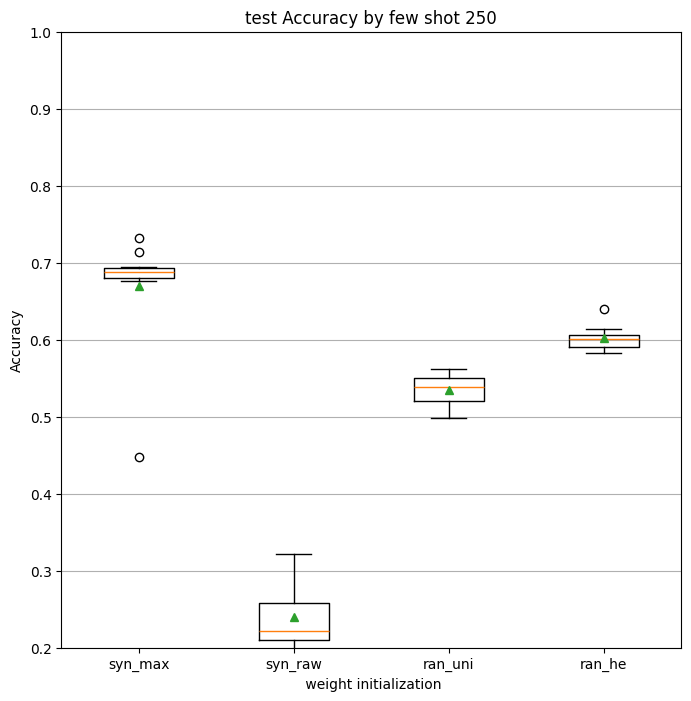

In [ ]:
label = ( "syn_max", "syn_raw", "ran_uni", "ran_he")

plt.figure(figsize=(8, 8))
plt.ylim(0.2, 1)
plt.boxplot([syn_max_list[250],syn_raw_list[250],ran_uni_list[250], ran_he_list[250]], tick_labels=label, showmeans=True)
plt.xlabel(" weight initialization")
plt.ylabel("Accuracy")
plt.title("test Accuracy by few shot 250")
plt.grid(axis='y')
plt.show()

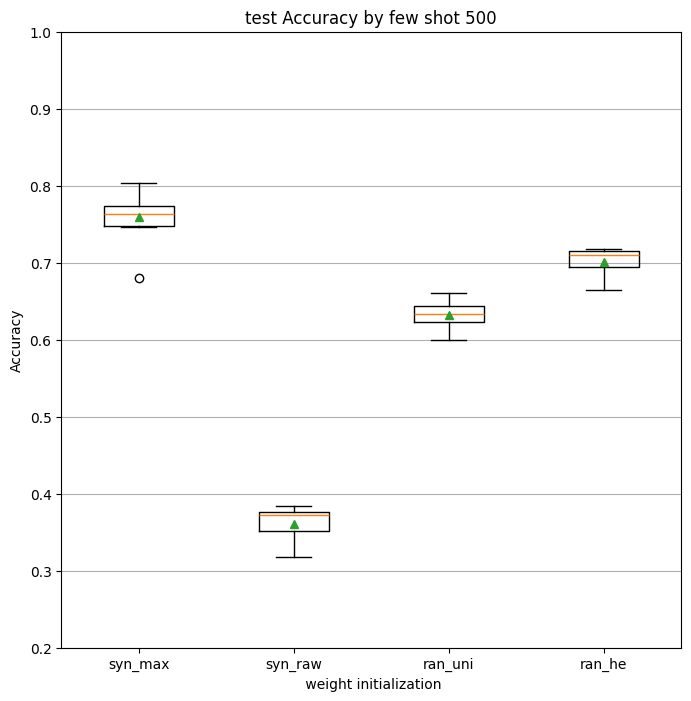

In [ ]:
label = ( "syn_max", "syn_raw", "ran_uni", "ran_he")

plt.figure(figsize=(8, 8))
plt.ylim(0.2, 1)
plt.boxplot([syn_max_list[500],syn_raw_list[500], ran_uni_list[500], ran_he_list[500]], tick_labels=label, showmeans=True)
plt.xlabel(" weight initialization")
plt.ylabel("Accuracy")
plt.title("test Accuracy by few shot 500")
plt.grid(axis='y')
plt.show()

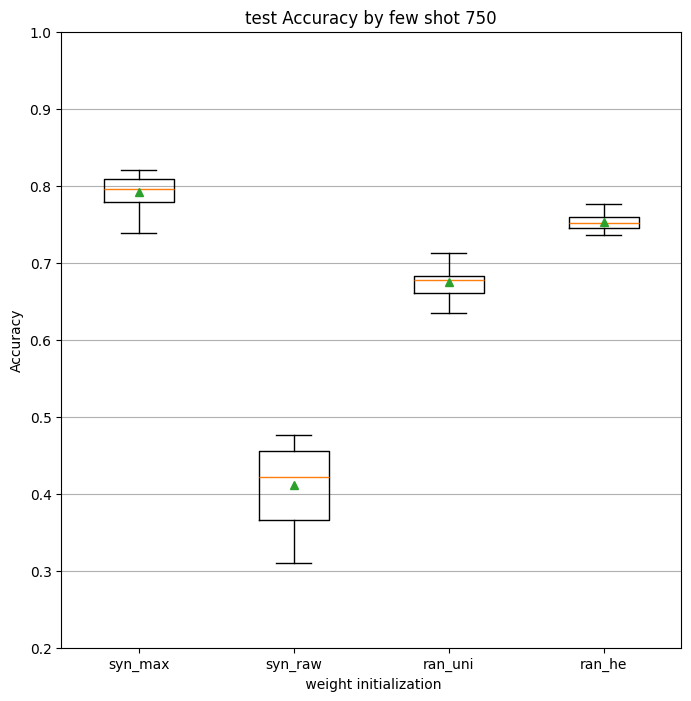

In [ ]:
label = ("syn_max", "syn_raw", "ran_uni", "ran_he")

plt.figure(figsize=(8, 8))
plt.ylim(0.2, 1)
plt.boxplot([syn_max_list[750],syn_raw_list[750], ran_uni_list[750], ran_he_list[750]], tick_labels=label, showmeans=True)
plt.xlabel(" weight initialization")
plt.ylabel("Accuracy")
plt.title("test Accuracy by few shot 750")
plt.grid(axis='y')
plt.show()

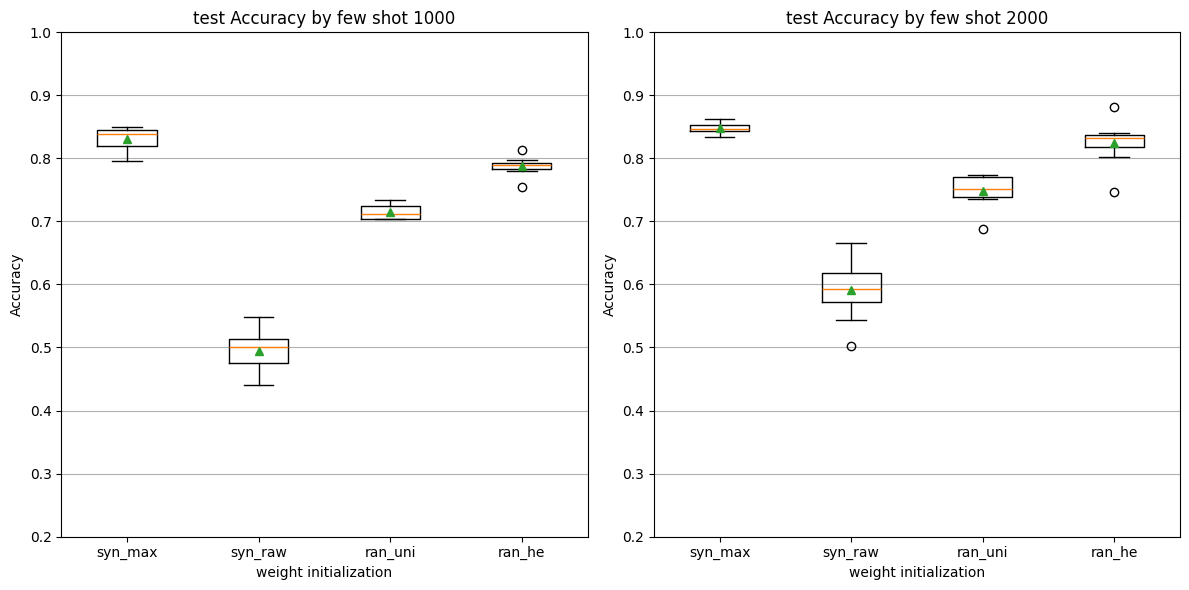

In [ ]:
label = ("syn_max", "syn_raw", "ran_uni", "ran_he")
nums = [1, 2]

plt.figure(figsize=(12, 6))  # 한 Figure에 다 그리기

for k in nums:
    plt.subplot(1, len(nums), k)
    plt.ylim(0.2, 1)
    plt.boxplot(
        [syn_max_list[1000*k],
         syn_raw_list[1000*k],
         ran_uni_list[1000*k],
         ran_he_list[1000*k]],
        tick_labels=label,
        showmeans=True
    )
    plt.xlabel("weight initialization")
    plt.ylabel("Accuracy")
    plt.title(f"test Accuracy by few shot {1000*k}")
    plt.grid(axis='y')

plt.tight_layout()
plt.show()
